In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import morton

In [29]:
df = pd.read_csv('data/2022-09-21_LaneChanges/Extracted_CleanLaneChanges/lane_change_31.csv', sep=';')

# remove unrelevant timestamp columns (except 'ts')
df.drop(columns=['sent.seconds','sent.microseconds','received.seconds','received.microseconds','sampleTimeStamp.seconds','sampleTimeStamp.microseconds',
                             'sent.seconds.1','sent.microseconds.1','received.seconds.1','received.microseconds.1','sampleTimeStamp.seconds.1','sampleTimeStamp.microseconds.1',
                             'IMULgtAcceleration', 'IMUVerAcceleration']
                             , axis=1, inplace=True)


In [30]:
OFFSET = 10
FACTOR_MULTIPLY = 10000

df['IMULatAcceleration']=df['IMULatAcceleration'].add(OFFSET)
df['SteeringWhlAngle']=df['SteeringWhlAngle'].add(OFFSET)

df['IMULatAcceleration'] = df.apply(lambda x: int(x['IMULatAcceleration']*FACTOR_MULTIPLY) , axis=1)
df['SteeringWhlAngle'] = df.apply(lambda x: int(x['SteeringWhlAngle']*FACTOR_MULTIPLY) , axis=1)

In [31]:
m = morton.Morton(dimensions=2, bits=18)

def set_value(row):
    return m.pack(int(row['IMULatAcceleration']), int(row['SteeringWhlAngle']))

df['morton'] = df.apply(set_value, axis=1)

### Manipulation

In [32]:
# declare df_manipulated where we will store a copy of original df, but with manipulations 
# '.copy()' is necessary otherwise the manipulation affects the original
df_manipulated = df.copy()

# MANIPULATION OFFSET TESTS
# 10^10 (1 with ten zeros)
#manipulation_offset = 10000000000
#manipulation_offset = 123456789
# 5 with nine zeros
#manipulation_offset = 5000000000
# powers of 2
#manipulation_offset = 65536*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2
# prime number
#manipulation_offset = 65537*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2*2
#manipulation_offset = 1000000
manipulation_offset = 0


# outliers are located at index 25:30 (for loop needs +1 for the top value)
# iterate through outliers
for i in range(25, 31):
    # reduce outlier value by subtracting manipulation_offset
    df_manipulated.loc[i, ['morton']] = df.loc[i, ['morton']] - manipulation_offset
    # extract manipulated values of IMULatAcceleration and SteeringWhlAngle (for current outlier)
    values_manipulated = m.unpack(int(df_manipulated.loc[i,['morton']]))
    
    # replace IMULatAcceleration and SteeringWhlAngle with unpacked manipulated morton values
    df_manipulated.loc[i, ['IMULatAcceleration']] = values_manipulated[0]
    df_manipulated.loc[i, ['SteeringWhlAngle']] = values_manipulated[1]
    
    # revert IMULatAcceleration and SteeringWhlAngle to before constants
    #df_manipulated.loc[i, ['IMULatAcceleration']] = (values_manipulated[0] / FACTOR_MULTIPLY) - OFFSET
    #df_manipulated.loc[i, ['SteeringWhlAngle']] = (values_manipulated[1] / FACTOR_MULTIPLY) - OFFSET


df_manipulated.iloc[22:34]

#values_manipulated = m.unpack(df.loc[i,['morton']])
# revert to before constants
#values[0] = (values[0] / FACTOR_MULTIPLY) - OFFSET # lat acceleration
#values[1] = (values[1] / FACTOR_MULTIPLY) - OFFSET # steering angle

#test = m.unpack(17179869183)
#test[0] = (test[0] / FACTOR_MULTIPLY) - OFFSET # lat acceleration
#test[1] = (test[1] / FACTOR_MULTIPLY) - OFFSET # lat acceleration
#test

,IMULatAcceleration,ts,SteeringWhlAngle,morton
22,97875,1663765176798990,101015,15399162671
23,113090,1663765176899265,104726,16236368428
24,122270,1663765176998981,108378,16533644252
25,132640,1663765177099030,112187,28088995466
26,141735,1663765177199269,115537,28526208535
27,149555,1663765177299073,117636,28735866149
28,141140,1663765177399021,117539,28531693850
29,147430,1663765177499252,115390,28544196284
30,138505,1663765177598982,111171,28107677771
31,126180,1663765177699045,106582,16581162552


### Plots

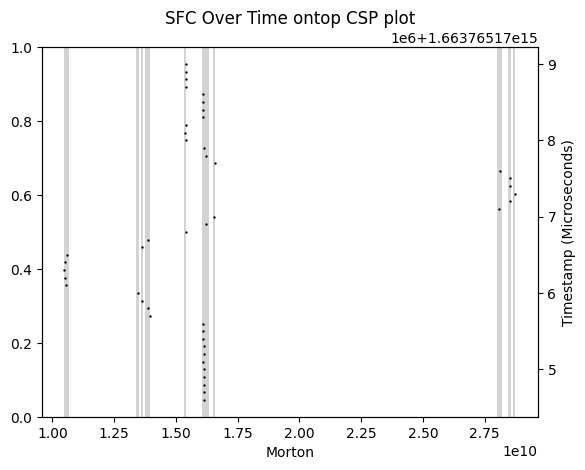

In [33]:
fig, ax = plt.subplots()
ax.hist(df_manipulated['morton'], bins=200, color='lightgray')
ax.set_ylim([0,1])
ax2 = ax.twinx()
ax2.scatter(x=df_manipulated['morton'],y=df_manipulated['ts'], c='black', s=0.5)
ax.set_xlabel('Morton')
ax2.set_title("SFC Over Time ontop CSP plot")
ax2.set_ylabel('Timestamp (Microseconds)')
plt.show()

In [34]:
# whole bell shape
#df_manipulated = df_manipulated.iloc[25:31]
# just growth
#df_manipulated = df_manipulated.iloc[25:28]
# other area
#df_manipulated = df_manipulated.iloc[30:50]


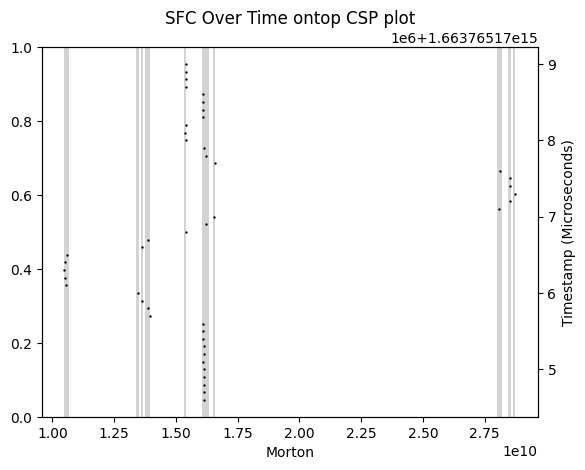

In [35]:
fig, ax = plt.subplots()
ax.hist(df_manipulated['morton'], bins=200, color='lightgray')
ax.set_ylim([0,1])
ax2 = ax.twinx()
ax2.scatter(x=df_manipulated['morton'],y=df_manipulated['ts'], c='black', s=0.5)
ax.set_xlabel('Morton')
ax2.set_title("SFC Over Time ontop CSP plot")
ax2.set_ylabel('Timestamp (Microseconds)')
plt.show()

<Axes: title={'center': 'Lateral acceleration and Steering angle against Timestamp'}, xlabel='Timestamp (Microseconds)', ylabel='Steering Angle (°) | Lateral Acceleration (m/s²)'>

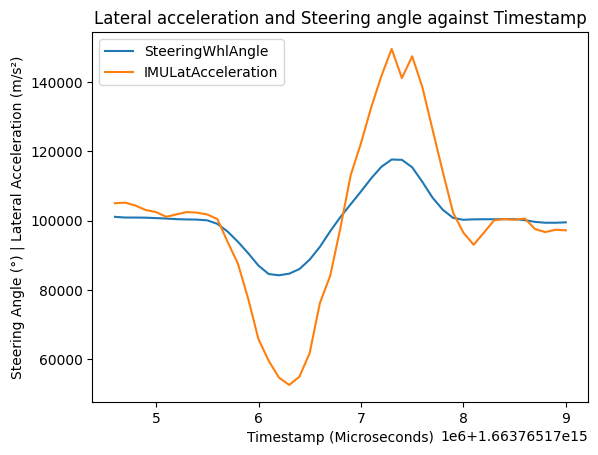

In [36]:
df_manipulated.plot(x='ts', y=['SteeringWhlAngle', 'IMULatAcceleration'], title='Lateral acceleration and Steering angle against Timestamp', xlabel='Timestamp (Microseconds)', ylabel='Steering Angle (°) | Lateral Acceleration (m/s\u00B2)')